<a href="https://colab.research.google.com/github/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/blob/main/Notebooks/3_Modelo_Vehiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: Modelado del conteo vehicular en CABA
En esta notebook vamos modelar el conteo vehicular en CABA previo a la cuarentena con un modelo Prophet. Este modelo debe ser capaz de "entender" las estacionalidades que observamos anteriormente en los datos (diaria, semanal) y además incorporar los efectos de los feriados y variables meteorológicas externas.

Finalmente, utilizaremos el modelo entrenado para extrapolar el conteo vehicular a la cuarentena, obteniendo el "cómo hubiese sido" del conteo vehicular de no haber habido cuarentena, según el modelo.

##1. Librerías y datos
En primer lugar cargamos las librerías necesarias. Notarán que además de cargarlas, algunas fueron desinstaladas y otras instaladas. Esto se debe a un problema con las versiones de estas librerías en Colab y que puede devolver algún error o advertencia cuando se las usa.

Además, se descarga el repositorio de este práctico (https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos) donde se encuentran todos los datos y modelos que se usarán.

Corra las siguientes líneas de código. Puede demorar unos pocos minutos.

In [ ]:
## Instalado de versiones compatibles ##
!pip uninstall fbprophet -y
!pip install cmdstanpy==0.9.68
!pip install pystan==2.19.1.1
!pip install prophet

## Carga de librerías ##
from prophet import Prophet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import json
from prophet.utilities import regressor_coefficients
from prophet.serialize import model_from_json

## Descarga del repositorio ##
!git clone https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos.git
!unzip Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Modelos/Modelo_vehiculos.zip

Found existing installation: fbprophet 0.7.1
Uninstalling fbprophet-0.7.1:
  Successfully uninstalled fbprophet-0.7.1
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 45 kB 2.3 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
     |████████████████████████████████| 65 kB 2.4 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640418 sha256=6f3609050a61b3caa86e238762bed9382b6da01cf0859e2210f34ef2044aa060
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
Cloning into 'Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 101 (delta 28), reused 76 (delta 14

Se cargan los datos, en primer lugar la información de conteo vehicular. Particularmente, Prophet necesita de input un DataFrame o matríz con al menos dos columnas de nombres:


1.   **ds**: Contiene la información del tiempo, debe estar en formato *datetime* y sin un timezone. En este caso son todas las horas desde 01/01/2019 00:00:00 hasta 19/03/2020 23:00:00	(previo a la cuarentena)
2.   **y**: Es la variable respuesta. En este caso es el logaritmo en base 10 del conteo de vehículos que atravesaron los peajes de CABA en su respectiva hora **ds**. La transformación log10 de la variable fue importante ya que fuerza a que las predicciones en escala real sean positivas.


También se pueden agregar otras columnas que funcionan como regresoras adicionales. En este caso se agregaron:



1.   **precipitaciones**: Ocurrencia de precipitaciones en la hora **ds** (1: Ocurrencia, 0: No ocurrencia)
2.   **temperatura**: Temperatura media ocurrida en la hora **ds**, en °C.
3.   **es_finde**: Indicador lógico que diferencia las horas **ds** que pertenecen al fin de semana de las que no.
4.   **es_semana**: Similar a **es_finde** pero para los días de semana.

In [ ]:
df_prophet = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/df_prophet_train.csv')

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format = '%Y-%m-%dT%H:%M:%SZ')
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None) #quito el timezone

df_prophet

,ds,y,precipitaciones,temperatura,es_finde,es_semana
0,2019-01-01 00:00:00,3.356981,0,24.9,False,True
1,2019-01-01 01:00:00,3.972619,0,25.3,False,True
2,2019-01-01 02:00:00,4.107515,0,25.3,False,True
3,2019-01-01 03:00:00,3.944285,0,24.9,False,True
4,2019-01-01 04:00:00,3.686904,0,24.2,False,True
...,...,...,...,...,...,...
10651,2020-03-19 19:00:00,4.169028,0,22.6,False,True
10652,2020-03-19 20:00:00,4.136023,0,21.5,False,True
10653,2020-03-19 21:00:00,4.120344,0,20.5,False,True
10654,2020-03-19 22:00:00,4.124472,0,19.4,False,True


La información de feriados se incorpora en un DataFrame o matríz distinto. Este dataframe tiene que tener las columnas:

1.   **ds**: En este caso, como los feriados son diarios (y no horarios), la resolución de **ds** es diaria.
2.   **holiday**: Denominación o nombre del feriado. Es importante que el mismo feriado en años distintos tenga el mismo nombre, de lo contrario el modelo los tomará como feriados distintos.

In [ ]:
feriados = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/feriados.csv')
feriados

,ds,holiday
0,2019-01-01,Año Nuevo [New Year's Day]
1,2019-03-04,Día de Carnaval [Carnival's Day]
2,2019-03-05,Día de Carnaval [Carnival's Day]
3,2019-03-24,Día Nacional de la Memoria por la Verdad y la ...
4,2019-04-18,Semana Santa (Jueves Santo) [Holy day (Holy T...
5,2019-04-19,Semana Santa (Viernes Santo) [Holy day (Holy ...
6,2019-04-21,Día de Pascuas [Easter Day]
7,2019-04-02,Día del Veterano y de los Caidos en la Guerra ...
8,2019-05-01,Día del Trabajo [Labour Day]
9,2019-05-25,Día de la Revolucion de Mayo [May Revolution Day]


##2. Entrenamiento del modelo
Dada la cantidad de información incorporada y la cantidad de estacionalidades a detectar, es necesario que el modelo realice muchas cadenas de Markov (parámetro *mcmc_samples*) para que las estimaciones sean buenas. En este caso, para alcanzar una buena estimación, se necesitó ```mcmc_samples = 1000```. En consecuencia, el entrenamiento demora varias horas, por lo que el modelo fue previamente entrenado y guardado utilizando el siguiente código:

```python
## Entrenamiento del modelo ##
m = Prophet(growth = "flat",
            changepoint_range = 0.8, #No se usa por que growth = "flat"
            changepoint_prior_scale = 0.05, #No se usa por que growth = "flat"
            n_changepoint = 25, #No se usa por que growth = "flat"
            yearly_seasonality = True,
            daily_seasonality = False, #Se separa en semana y finde con add_seasonality, más abajo
            weekly_seasonality = True,
            mcmc_samples = 1000, #Cuanto más mejor pero tarda mucho...
            seasonality_mode = "additive", #Siendo que esta todo en log, al reconvertirlo a identidad las relaciones son multiplicativas
            seasonality_prior_scale = 0.827,
            uncertainty_samples = 2000,
            holidays=feriados,
            holidays_prior_scale = 0.0198)

m.add_seasonality("diaria_semana", 1, mode = "additive", condition_name = "es_semana", fourier_order = 5) #Tendencia diaria dia de semana
m.add_seasonality("diaria_finde", 1, mode = "additive", condition_name = "es_finde", fourier_order = 5) #Tendencia diaria fin de semana
m.add_regressor("precipitaciones", mode = "additive") #Regresor precipitaciones
m.add_regressor("temperatura", mode = "additive") #Regresor temperatura

m.fit(df_prophet, control={'max_treedepth': 30}) #Menos que esto suele tirar un warining para este problema en particular


## Guardado del modelo ##
import json
from prophet.serialize import model_to_json
with open('Modelo_vehiculos.json', 'w') as fout:
    json.dump(model_to_json(m), fout)
```

Los parámetros de la función para el entrenamiento del modelo son:


*   ```growth```: Función basal de la tendencia. Puede tomar los valores de ```"linear"```, ```"logistic"``` o ```"flat"```. En este caso, usaremos ```"flat"``` ya que, con solo un poco mas de un año, no se puede observar claramente un cambio de tendencia
*   ```changepoint_range```, ```changepoint_prior_scale```  y ```n_changepoint```: Son los parámetros que regulan la cantidad y sensibilidad de los cambios de tendencia a detectar. Como ```growth = "flat"```, estos parámetros no importan en este caso.
*   ```yearly_seasonality```, ```weekly_seasonality``` y ```daily_seasonality```: Booleanos aunque también pueden tomar el valor ```"auto"```. Indican si el modelo debe buscar y ajustar una estacionalidad anual, semanal y/o diaria. En este caso ```daily_seasonality = False``` ya que nos interasa diferencias los fines de semana de los días de semana que se explicita con ```m.add_seasonality```.
*   ```seasonality_mode```: Puede ser ```"additive"``` o ```"multiplicative"```. En este casos se selecciona "additive": como la variable respuesta **y** está en escala logaritmica, su transformación a escala real implica una multiplicación de las estacionalidades.
*   ```seasonality_prior_scale```: Valor prior de variabilidad de todas las estacionalidades para la regresión bayesiana. A más información de los datos, menor es la importancia de del valor explicitado. Los autores recomiendan valores entre 0.01 y 10.
*   ```holidays``` y ```holidays_prior_scale```: DataFrame de feriados y valor prior de variabilidad deel efecto de los feriados para la regresión bayesiana. A más información de los datos, menor es la importancia de del valor explicitado. Los autores recomiendan valores entre 0.01 y 10.
*   ```mcmc_samples```: Número de cadenas de Markov a realizar para las regresiones bayesianas. Si ```mcmc_samples = 0```, la estimación no es por rergesión bayesiana sino por MAP. A datos complejos se recomienda un valor alto, a costa de tiempo de computo.
*   ```uncertainty_samples```: Número de simulaciones realizadas para estimación de los intervalos de incerteza. Cuanto mayor sea el número, mejor será la estimación a costa de tiempo de computo.


Además, al modelo se le incorporan:

*   ```add_seasonality```: Agrega una estacionalidad específica. Debe especificarse una denominacion, un largo de período (en días) y la cantidad de harmónicos de Fourier. En este caso se agregan 2: estacionalidad diaria para días de la semana y otra para diás del fin de semana. Los datos pertenecientes a una u otra se diferencian por las columnas *es_semana* y *es_finde* del DataFrame.
*   ```add_regressor```: Agrega una variable explicativa. Se debe indicar la columna correspondiente del DataFrame.


Estos son algunos de los parámetros y funciones que se pueden especificar, para más información puede consultar https://facebook.github.io/prophet/ o corriendo ```help(Prophet)```. También puede entrenar el mismo modelo en R donde la sintaxis es muy similar y puede ver como hacerlo en desde el mismo link. La documentación del paquete para R se encuentra en https://cran.r-project.org/web/packages/prophet/prophet.pdf. No existe una documentación tan detallada en Python por lo que ésta es útil para ambos lenguajes.



---

A continuación se carga el modelo ya entrenado y guardado en el archivo *Modelo_vehiculos.json*:


In [ ]:
with open('Modelo_vehiculos.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

resultados = m.predict(df_prophet)

##3. Análisis de las estimaciones del modelo
El método ```m.predict(df_prophet)``` devuelve las predicciones del modelo sobre el DataFrame ```df_prophet``` en formato DataFrame. Las columnas nuevas son:


*   **trend**, **trend_lower**, **trend_upper**: Valores de la tendencia estimada y su intervalo de incertidumbre (valor inferior y superior) respectivamente.
*   **yearly**, **yearly_lower**, **yearly_upper**: Valores de la variación de la variable respuesta producto de por la estacionalidad anual estimada y su intervalo de incertidumbre (valor inferior y superior) respectivamente.
*   **weekly**, **weekly_lower**, **weekly_upper**: Lo mismo para la estacionalidad semanal.
*   **diaria_semana**, **diaria_semana_lower**, **diaria_semana_upper**: Lo mismo para la estacionalidad diaria de los días de la semana.
*   **diaria_finde**, **diaria_finde_lower**, **diaria_finde_upper**: Lo mismo para la estacionalidad diaria de los días del fin de semana.
*   ***feriado***, ***feriado*_lower**, ***feriado*_upper**: Valores de la variación de la variable respuesta producto del respectivo feriado estimada y su intervalo de incertidumbre (valor inferior y superior) respectivamente.
*   **temperatura**, **temperatura_lower**, **temperatura_upper**: Lo mismo para la **temperatura**
*   **precipitaciones**, **precipitaciones**, **precipitaciones**: Lo mismo para las **precipitaciones**
*   **extra_regressors_additive**, **extra_regressors_additive_lower**, **extra_regressors_additive_upper**: Suma de los valores de variación de todas las variables regresoras aditivas (**precipitaciones** y **temperatura**)
*   **multiplicative_terms**, **multiplicative_terms_lower**, **multiplicative_terms_upper**: Lo mismo para las variables multiplicativas (ninguna en este caso)
*   **yhat**, **yhat_lower**, **yhat_upper**: Valores predichos de la variable respuesta y su intervalo de incertidumbre (valor inferior y superior) respectivamente.

In [ ]:
resultados.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day]_lower,Año Nuevo [New Year's Day]_upper,Día Nacional de la Memoria por la Verdad y la Justicia [Memory's National Day for the Truth and Justice],...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 00:00:00,4.054268,3.350793,3.665856,4.052543,4.056007,-0.198875,-0.221093,-0.1763,0.0,...,0.004639,0.000790,0.008583,0.004178,-0.002901,0.011031,0.0,0.0,0.0,3.500321
1,2019-01-01 01:00:00,4.054268,3.179748,3.487056,4.052543,4.056007,-0.198875,-0.221093,-0.1763,0.0,...,0.004515,0.000621,0.008449,0.004007,-0.003085,0.010832,0.0,0.0,0.0,3.330399
2,2019-01-01 02:00:00,4.054268,2.996620,3.317692,4.052543,4.056007,-0.198875,-0.221093,-0.1763,0.0,...,0.004264,0.000416,0.008152,0.003835,-0.003223,0.010636,0.0,0.0,0.0,3.154950
3,2019-01-01 03:00:00,4.054268,2.938383,3.249757,4.052543,4.056007,-0.198875,-0.221093,-0.1763,0.0,...,0.003899,0.000094,0.007779,0.003664,-0.003386,0.010447,0.0,0.0,0.0,3.094304
4,2019-01-01 04:00:00,4.054268,3.090644,3.406006,4.052543,4.056007,-0.198875,-0.221093,-0.1763,0.0,...,0.003436,-0.000371,0.007295,0.003493,-0.003574,0.010293,0.0,0.0,0.0,3.245459


Estos resultados se pueden visualizar fácilmente con el comando ```m.plot_components(resultados)```:



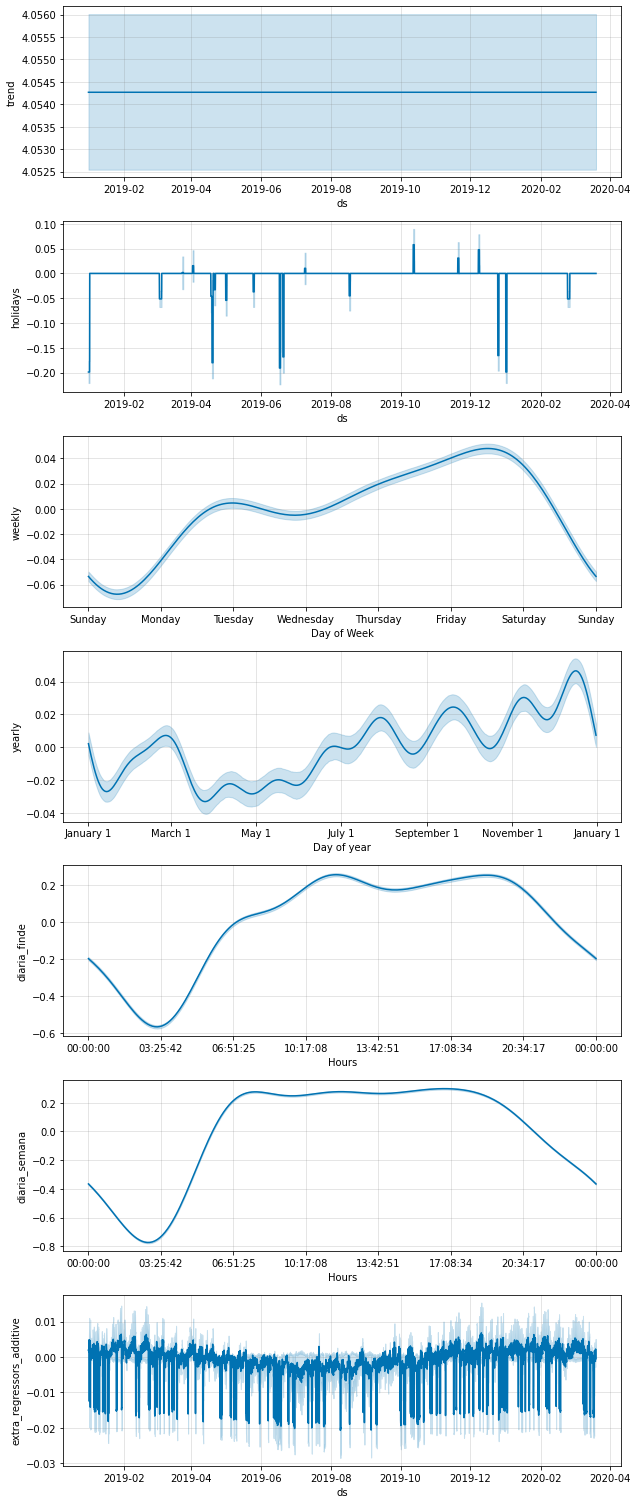

In [ ]:
fig = m.plot_components(resultados)

*   ¿Cómo es la tendencia estimada?
*   Observe las estacionalidades ¿Se corresponden a lo observado en la descriptiva? ¿Cuáles son las principales diferencias entre los días de la semana y los del fin de semana?
*   Observe el efecto de los feriados. Algunos tienen un efecto positivo y otros negativo sobre el conteo vehicular. ¿Como podemos observar cuales tienen un efecto "significativo"? ¿Puede identificar alguno? ¿Cuales son los feriados que parecieran tener el efecto más importante?
*   Observe el efecto de los regresores extra ¿Qué variables están incluídas ahí? ¿Como pareciera ser su efecto sobre el conteo vehicular?


El efecto aditivo (y su intervalo de incerteza) de las variables adcionales puede obtenerse con la función ```regressor_coefficients(m)```.



In [ ]:
coeficientes = regressor_coefficients(m)
coeficientes

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,precipitaciones,additive,0.000000,-0.021767,-0.016206,-0.010471
1,temperatura,additive,19.698264,-0.000102,0.000376,0.000849


A continuación se graficaron estas estimaciones. Se considera que un intervalo de incerteza que no contiene al 0 es significativo.

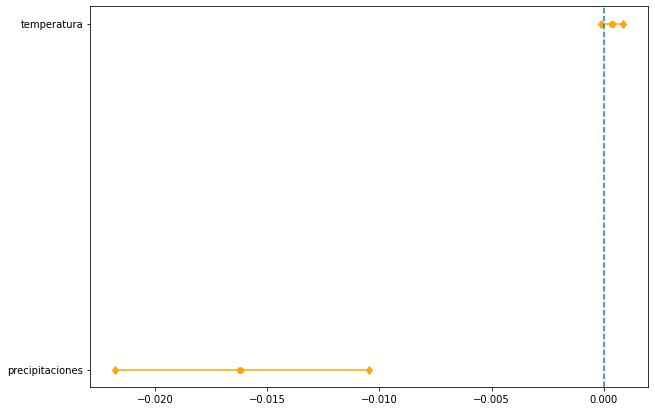

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
for lower, upper, center, y in zip(coeficientes['coef_lower'], coeficientes['coef_upper'], coeficientes['coef'], range(len(coeficientes))):
  ax.plot((lower,upper),(y,y),'d-',color='orange')
  ax.scatter(center, y, color='orange')
plt.yticks(range(len(coeficientes)),list(coeficientes['regressor']))
ax.axvline(x=0, linestyle = 'dashed')
plt.show()



*   ¿Cómo afectan la temperatura y la precipitación al conteo vehicular?



Estudiemos cómo es el ajuste del modelo. Observemos los predichos y los observados. Modifique el código siguiente para explorar el ajuste del modelo a distintas fechhas y en escala logaritmica o de la variable respuesta.

El objeto ```escala_logaritmica``` define si se grafica al logaritmo del conteo vehicular (```escala_logaritmica = True```) o bien al conteo vehicular sin transformación logaritmica (```escala_logaritmica = False```). Recuerde que las fechas deben conservar el formato 'YYYY-MM-DD' y que las fechas mínimas y máximas son "2019-01-01" y "2020-03-20"



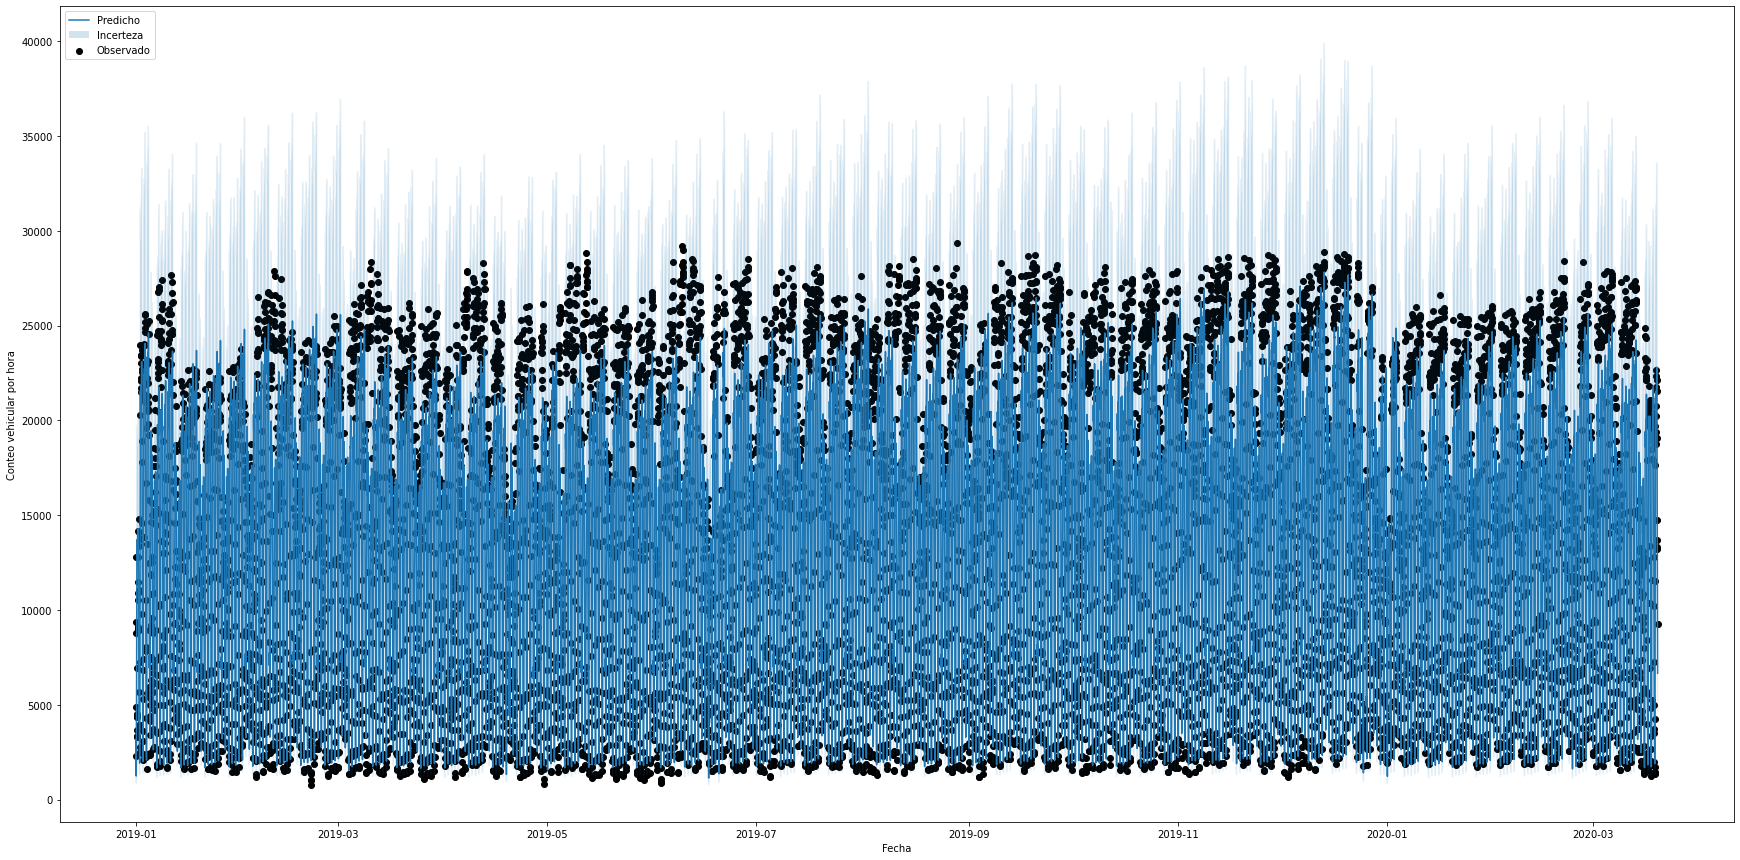

In [ ]:
##### Modifique las siguientes líneas de código #####
fecha_inicial = "2019-01-01"
fecha_final = "2020-03-20"
escala_logaritmica = False  # True o False



##### NO modifique las siguientes líneas de código #####
df_total = df_prophet.merge(resultados, on='ds', how='left')

if escala_logaritmica == False:
  df_total['y'] = 10**df_total['y']
  df_total['yhat'] = 10**df_total['yhat']
  df_total['yhat_lower'] = 10**df_total['yhat_lower']
  df_total['yhat_upper'] = 10**df_total['yhat_upper']

df_total = df_total[(df_total['ds'] >= fecha_inicial) & (df_total['ds'] <= fecha_final)]

fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(df_total['ds'], df_total['yhat'], label='Predicho')
ax.plot(df_total['ds'], df_total['yhat_lower'], color='tab:blue', alpha=0.1)
ax.plot(df_total['ds'], df_total['yhat_upper'], color='tab:blue', alpha=0.1)
ax.fill_between(df_total['ds'], df_total['yhat_lower'], df_total['yhat_upper'], alpha=0.2, label='Incerteza')
ax.scatter(df_total['ds'], df_total['y'], color='black', label='Observado')
ax.legend(loc="upper left")
ax.set_xlabel('Fecha')
ax.set_ylabel('Conteo vehicular por hora')
plt.show()

Otro gráfico clásico que se puede utilizar es el de observados vs predichos.
En esta ocasión, además puede incorporar las barras de incertidumbre de los predichos con el objeto ```barras_de_incertidumbre```



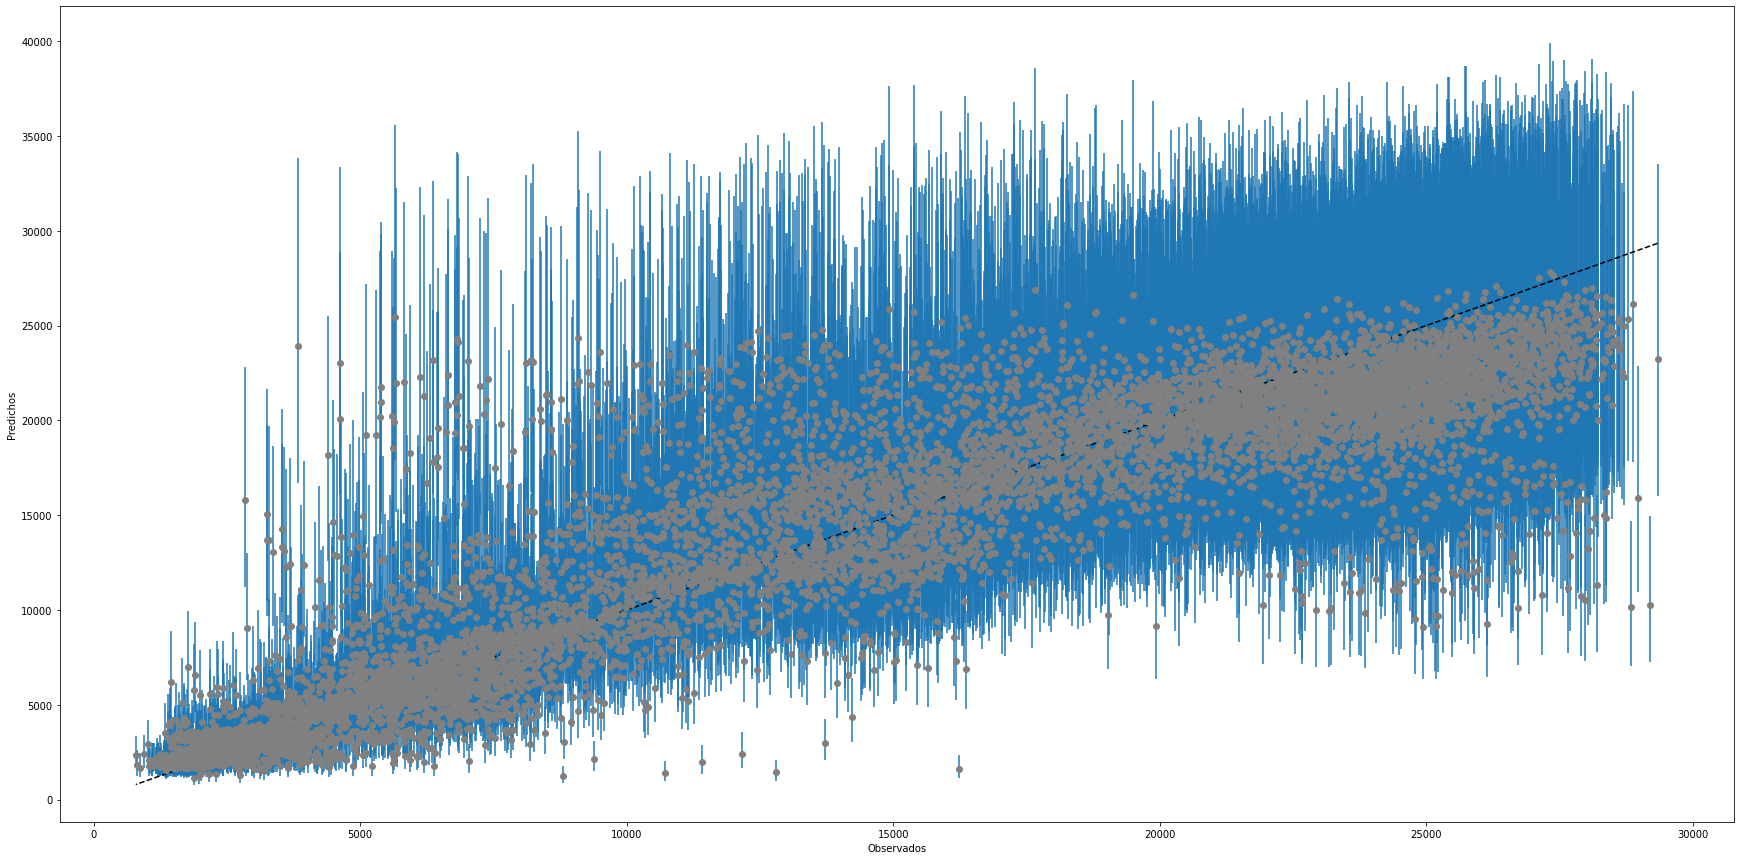

In [ ]:
##### Modifique las siguientes líneas de código #####
fecha_inicial = "2019-01-01"
fecha_final = "2020-03-20"
escala_logaritmica = False  # True o False
barras_de_incertidumbre = True # True o False





##### NO modifique las siguientes líneas de código #####
df_total = df_prophet.merge(resultados, on='ds', how='left')

if escala_logaritmica == False:
  df_total['y'] = 10**df_total['y']
  df_total['yhat'] = 10**df_total['yhat']
  df_total['yhat_lower'] = 10**df_total['yhat_lower']
  df_total['yhat_upper'] = 10**df_total['yhat_upper']

df_total = df_total[(df_total['ds'] >= fecha_inicial) & (df_total['ds'] <= fecha_final)]

p1 = max(df_total['yhat'].max(), df_total['y'].max())
p2 = min(df_total['yhat'].min(), df_total['y'].min())

if barras_de_incertidumbre:
  y_errormin = df_total['yhat'] - df_total['yhat_lower']
  y_errormax = df_total['yhat_upper'] - df_total['yhat']
  y_error = [y_errormin, y_errormax]
else:
  y_error = 0


fig, ax = plt.subplots(figsize=(30, 15))
ax.errorbar(df_total['y'], df_total['yhat'], yerr=y_error, color = 'grey', fmt='o', ecolor='#1F77B4')
ax.plot([p1, p2], [p1, p2], color = "black", linestyle = 'dashed')
ax.set_xlabel('Observados')
ax.set_ylabel('Predichos')
plt.show()


*   ¿Donde y cuando se encuentran los mayores error de la predicción?
*   ¿Considera que la predicción realizada es buena?
*   ¿Qué otras técnicas considera relevantes para evaluar la bondad de ajuste?


##4. Predicciones durante la cuarentena
A partir del modelo entrenado previamente, vamos a realizar las predicciones de circulación en fechas que no fueron parte de los datos de entrenamiento. Para ello, en primer lugar debemos cargar los datos necesarios, estos son iguales a los utilizados para el entrenamiento del modelo pero su fecha final es el 31/12/2020, 

In [ ]:
df_prophet_entero = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/df_prophet_entero.csv')

df_prophet_entero['ds'] = pd.to_datetime(df_prophet_entero['ds'], format = '%Y-%m-%dT%H:%M:%SZ')
df_prophet_entero['ds'] = df_prophet_entero['ds'].dt.tz_localize(None) #quito el timezone

df_prophet_entero

,ds,y,precipitaciones,temperatura,es_finde,es_semana
0,2019-01-01 00:00:00,3.356981,0,24.9,False,True
1,2019-01-01 01:00:00,3.972619,0,25.3,False,True
2,2019-01-01 02:00:00,4.107515,0,25.3,False,True
3,2019-01-01 03:00:00,3.944285,0,24.9,False,True
4,2019-01-01 04:00:00,3.686904,0,24.2,False,True
...,...,...,...,...,...,...
17539,2020-12-31 19:00:00,4.149250,0,27.9,False,True
17540,2020-12-31 20:00:00,4.184720,0,26.4,False,True
17541,2020-12-31 21:00:00,4.017868,0,24.9,False,True
17542,2020-12-31 22:00:00,3.450403,0,25.0,False,True


Ahora realizamos la predicción de la misma forma que lo hicimos para los datos de entrenamiento:

In [ ]:
resultados_entero = m.predict(df_prophet_entero)
resultados_entero.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day]_lower,Año Nuevo [New Year's Day]_upper,Día Nacional de la Memoria por la Verdad y la Justicia [Memory's National Day for the Truth and Justice],...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
17539,2020-12-31 19:00:00,4.054268,4.166564,4.489136,4.052543,4.056007,0.0,0.0,0.0,0.0,...,0.035618,0.032041,0.039135,0.002981,-0.004039,0.009832,0.0,0.0,0.0,4.329494
17540,2020-12-31 20:00:00,4.054268,4.075671,4.395290,4.052543,4.056007,0.0,0.0,0.0,0.0,...,0.036534,0.032961,0.040080,0.002811,-0.004171,0.009659,0.0,0.0,0.0,4.235215
17541,2020-12-31 21:00:00,4.054268,3.954040,4.265149,4.052543,4.056007,0.0,0.0,0.0,0.0,...,0.037464,0.033881,0.040994,0.002641,-0.004338,0.009495,0.0,0.0,0.0,4.104717
17542,2020-12-31 22:00:00,4.054268,3.814455,4.126213,4.052543,4.056007,0.0,0.0,0.0,0.0,...,0.038402,0.034827,0.041921,0.002471,-0.004515,0.009337,0.0,0.0,0.0,3.972725
17543,2020-12-31 23:00:00,4.054268,3.707258,4.014351,4.052543,4.056007,0.0,0.0,0.0,0.0,...,0.039344,0.035733,0.042921,0.002301,-0.004710,0.009150,0.0,0.0,0.0,3.857483


Observemos rápidamente como se ve la predicción comparada al conteo vehicular durante la cuarentena. Modifique el código siguiente según lo crea necesario.

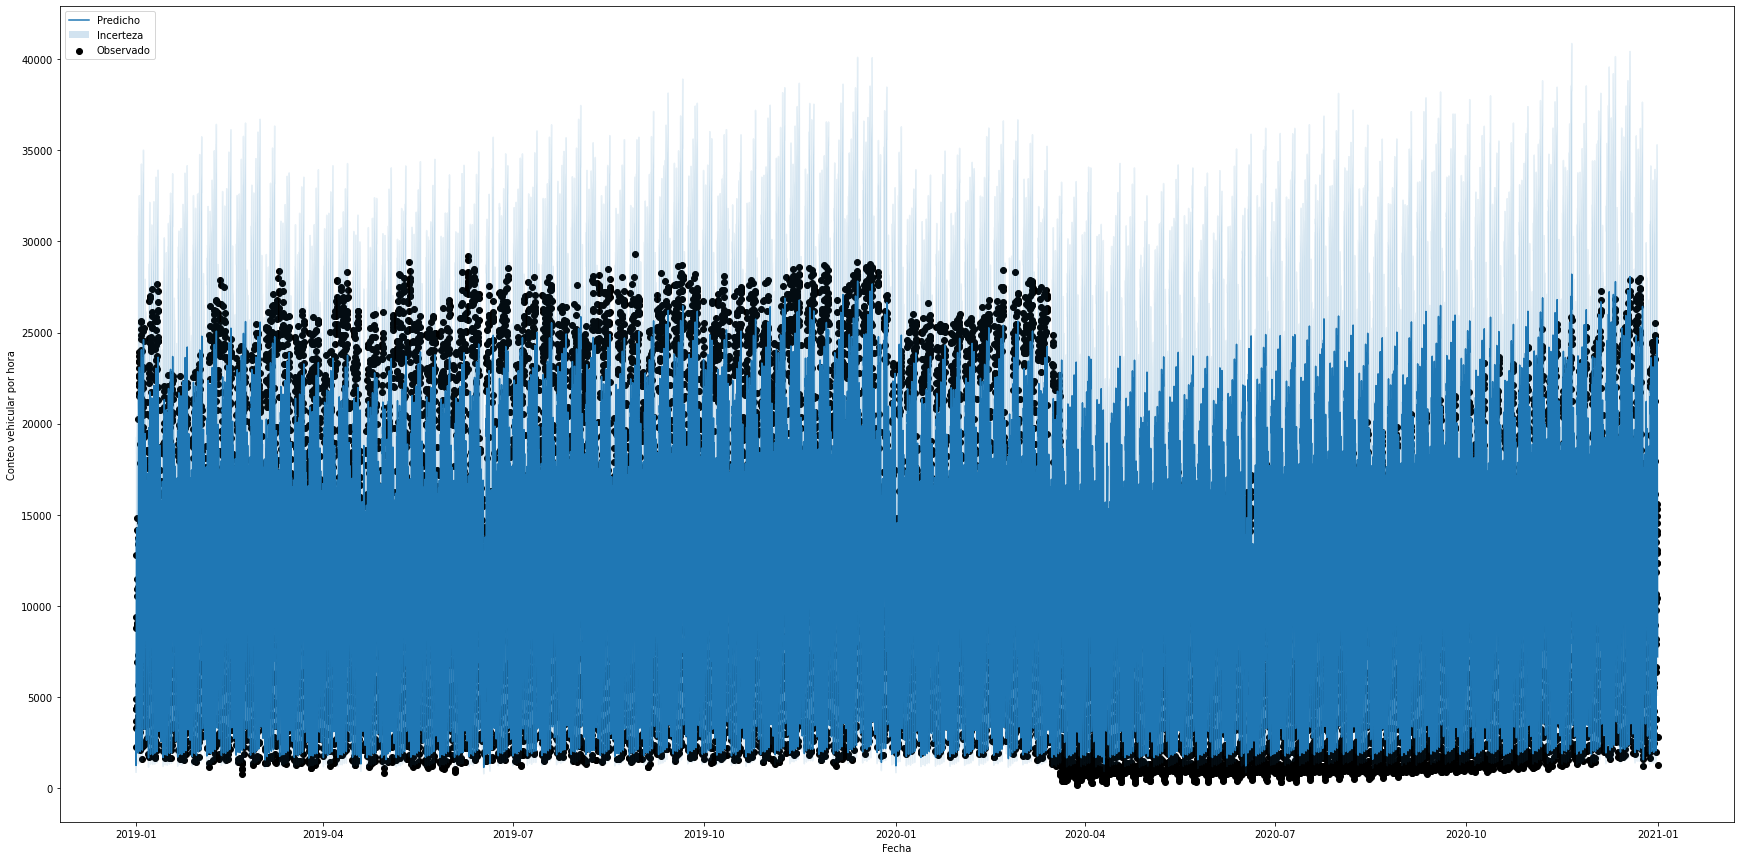

In [ ]:
##### Modifique las siguientes líneas de código #####
fecha_inicial = "2018-01-01"
fecha_final = "2022-12-31"
escala_logaritmica = False  # True o False




##### NO modifique las siguientes líneas de código #####
df_total = df_prophet_entero.merge(resultados_entero, on='ds', how='left')

if escala_logaritmica == False:
  df_total['y'] = 10**df_total['y']
  df_total['yhat'] = 10**df_total['yhat']
  df_total['yhat_lower'] = 10**df_total['yhat_lower']
  df_total['yhat_upper'] = 10**df_total['yhat_upper']

df_total = df_total[(df_total['ds'] >= fecha_inicial) & (df_total['ds'] <= fecha_final)]

fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(df_total['ds'], df_total['yhat'], label='Predicho')
ax.plot(df_total['ds'], df_total['yhat_lower'], color='tab:blue', alpha=0.1)
ax.plot(df_total['ds'], df_total['yhat_upper'], color='tab:blue', alpha=0.1)
ax.fill_between(df_total['ds'], df_total['yhat_lower'], df_total['yhat_upper'], alpha=0.2, label='Incerteza')
ax.scatter(df_total['ds'], df_total['y'], color='black', label='Observado')
ax.legend(loc="upper left")
ax.set_xlabel('Fecha')
ax.set_ylabel('Conteo vehicular por hora')
plt.show()

*   ¿Qué ocurre durante la cuarentena en cuanto a las predicciones y los valores observados?

Los resultados obtenidos fueron guardados en formato CSV y serán utilizados en la próxima notebook.